In [10]:
import psycopg2
import networkx as nx
from sshtunnel import SSHTunnelForwarder
import matplotlib.pyplot as plt

In [53]:
server = SSHTunnelForwarder(
    ('10.0.1.139', 22),
    ssh_username='bcadmin',
    ssh_pkey='/Users/mkf26/.ssh/id_ed25519',
    ssh_private_key_password='Poltergeist96!',
    remote_bind_address=('localhost', 5432)
)

server.start()

print(server.local_bind_port)  # show assigned local port
# work with `SECRET SERVICE` through `server.local_bind_port`.

conn = psycopg2.connect(
    database='digital_appraisal_new',
    user='bcadmin',
    host=server.local_bind_host,
    port=server.local_bind_port,
    password='090696')
cur = conn.cursor()

2023-11-17 15:52:56,327| ERROR   | Password is required for key /Users/mkf26/.ssh/id_ed25519


64431


In [62]:
#getting duplicate relationships from database
def getRelationships():
    cur.execute("""
    with DUPES as (
    SELECT
        f1.id AS file_id,
        f1.directory_id,
        f1.file_path,
        f1.file_name,
        f1.md5_hash,
        f1.digital_media_id,
        f1.format_id,
        f1.file_type,
        f1.size,
        f2.id AS duplicate_file_id,
        f2.file_name as duplicate_name,
        f2.file_path as duplicate_file_path,
        f2.digital_media_id as duplicate_media_id
    FROM
        files f1
    JOIN
        files f2
    ON
        f1.md5_hash = f2.md5_hash
    WHERE
        f1.digital_media_id != f2.digital_media_id
        AND f1.id != f2.id
        and f1.appraisal_decision is NULL
        and f2.appraisal_decision is NULL
    )
    
    select digital_media_id, duplicate_media_id,
    count(distinct file_id) as unique_duplicate_file_count
    from DUPES
    join media m1 on digital_media_id = m1.id
    join media m2 on duplicate_media_id = m2.id
    where m1.group_id = '1.1'
    and m2.group_id like '1.%'
    group by digital_media_id, duplicate_media_id
    order by unique_duplicate_file_count desc;""")
    relationships = cur.fetchall()
    #setting a cutoff on number of duplicates for analysis
    min_duplicates = 100
    relationships = list(set([(min(relation[0], relation[1]), max(relation[0], relation[1]), relation[2])  for relation in relationships if relation[2] > min_duplicates]))
    return relationships

# getting nodes from relationships (list of tuples created by above function)
def getNodes(relationships):
    #gets full list of media IDs and file counts from the DB
    cur.execute("""select id, file_count from 
    (select m.id, count(*) as file_count
    from media as m
    left join files as f
    on m.id = f.digital_media_id
    group by m.id
    order by m.id)
    where file_count != 1;""")
    media_ids_counts = cur.fetchall()
    #condenses digital_media_ids from a list of tuples (relationsips) into unique list to compare against
    relevant_media_ids = list(set([media_id for tup in relationships for media_id in tup[:2]]))
    #create list of nodes by comparing against the list of relevant media ids
    nodes = {item[0]: item[1] for item in media_ids_counts if item[0] in relevant_media_ids}
    return nodes

def getEdges(relationships):
    edges = [(relation[0], relation[1]) for relation in relationships]
    return edges

relationships = getRelationships()
nodes = getNodes(relationships)
edges = getEdges(relationships)

print(nodes)
print(edges)

{'D-0199': 10384, 'D-0200': 14410, 'D-0203': 33709, 'D-0204': 20075, 'D-0225': 29487, 'D-0226': 7126, 'D-0227': 238733, 'D-0238': 673706, 'D-0249A': 3744}
[('D-0199', 'D-0200'), ('D-0199', 'D-0204'), ('D-0203', 'D-0249A'), ('D-0203', 'D-0226'), ('D-0204', 'D-0227'), ('D-0203', 'D-0204'), ('D-0199', 'D-0203'), ('D-0199', 'D-0204'), ('D-0203', 'D-0225'), ('D-0199', 'D-0203'), ('D-0203', 'D-0204'), ('D-0204', 'D-0225'), ('D-0199', 'D-0227'), ('D-0203', 'D-0238'), ('D-0200', 'D-0249A'), ('D-0203', 'D-0227'), ('D-0199', 'D-0200'), ('D-0200', 'D-0203'), ('D-0200', 'D-0203'), ('D-0204', 'D-0226'), ('D-0199', 'D-0238'), ('D-0199', 'D-0249A'), ('D-0204', 'D-0238')]


{('D-0199',
  'D-0200'): Text(0.8830222197173554, 0.3213938056005782, '7039 duplicate files'),
 ('D-0199',
  'D-0204'): Text(0.24999997516473155, 0.4330127111208921, '193 duplicate files'),
 ('D-0203',
  'D-0249A'): Text(0.46984627448952015, 0.17101000632835756, '3834 duplicate files'),
 ('D-0203',
  'D-0226'): Text(-0.38302218743150634, 0.3213938056005782, '2763 duplicate files'),
 ('D-0204',
  'D-0227'): Text(-0.49999997516473144, -9.934107370046519e-09, '12097 duplicate files'),
 ('D-0203',
  'D-0204'): Text(-0.16317591045845936, 0.9254165727203649, '13523 duplicate files'),
 ('D-0199',
  'D-0203'): Text(0.5868241143768091, 0.4924038814676875, '7339 duplicate files'),
 ('D-0203',
  'D-0225'): Text(-0.38302218743150634, 0.663413987137119, '1964 duplicate files'),
 ('D-0204',
  'D-0225'): Text(-0.719846326643584, 0.6040228167903237, '436 duplicate files'),
 ('D-0199',
  'D-0227'): Text(0.250000049670537, -0.43301270118678475, '876 duplicate files'),
 ('D-0203',
  'D-0238'): Text(0.173

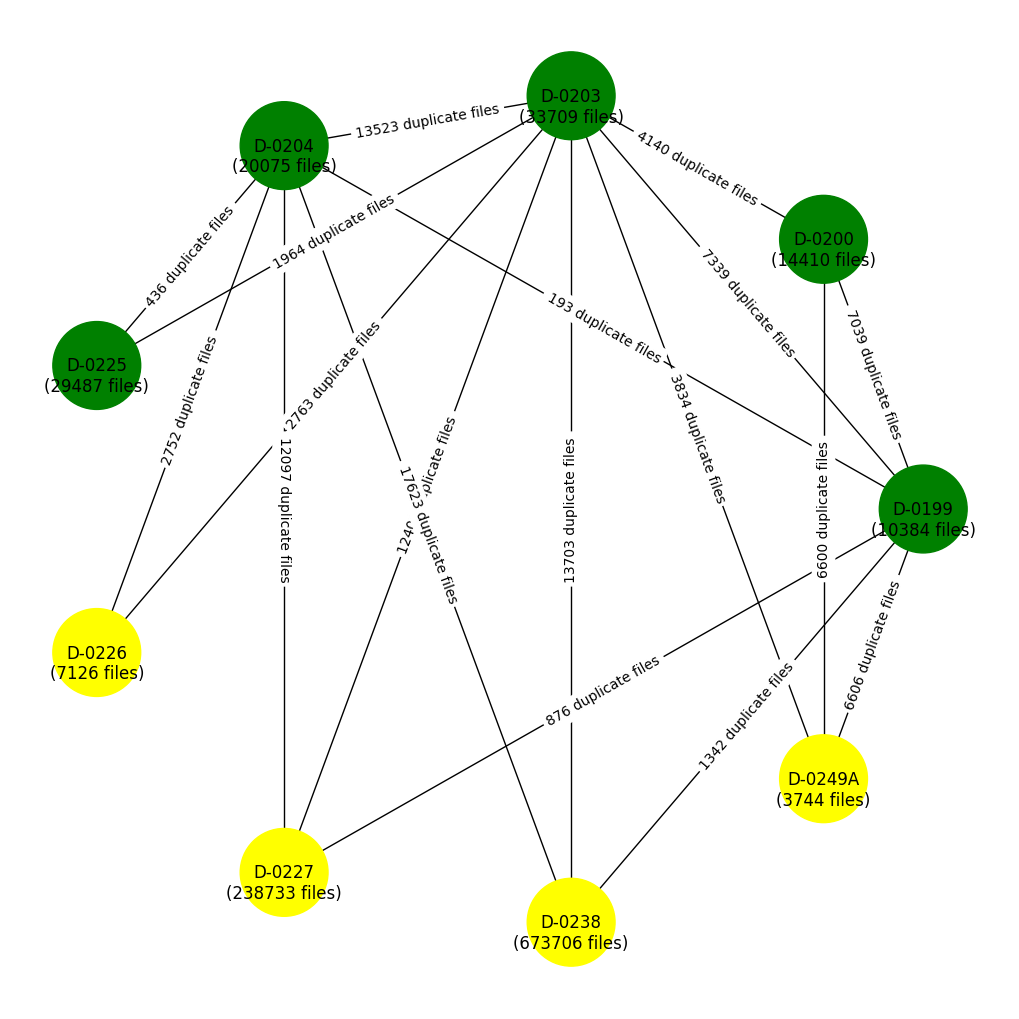

In [65]:
G = nx.Graph()

G.add_nodes_from(nodes.keys())
G.add_edges_from(edges)

plt.figure(figsize=(10, 10))

options = {
    'node_color': ['green' if n < 5 else 'yellow' for n in range(len(nodes))],
    'node_size': 4000,
    'width': 1,

}
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels = True, **options)

nx.draw_networkx_labels(
    G,
    pos,
    labels={media_id: f"\n\n({nodes[media_id]} files)" for media_id in nodes.keys()}
)

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={(relation[0], relation[1]): f"{relation[2]} duplicate files" for relation in relationships}
)


In [ ]:
cur.close()
conn.close()
server.stop()